# **ULMFit Text Classification for Salesforce[Case]**

### Data Preparation 

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/open?id=1DqPGG6l5hQ-0V9v7pzSt83keyuLNeBdP' # The shareable link
fluff, id = link.split('=')
print (id) # verify that you have everything after '='

1DqPGG6l5hQ-0V9v7pzSt83keyuLNeBdP


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('SFC_Case_3.txt')  
data = pd.read_csv('SFC_Case_3.txt', header=0, encoding='utf-8',delimiter='%%',engine='python')

In [7]:
data.head(5)

,Reason,Description,Unnamed: 2
0,Admin Portal,\tcustomer is saying he cannot scroll down ins...,NaN
1,Mobile App,\tCustomer Education,NaN
2,Site Outage,\tcustomer was not able to access FMW for a ha...,NaN
3,Service Work Related,\tCustomer needs a unit removed from one of th...,NaN
4,Software,\tTanner needs his login credentials.,NaN


In [0]:
data = data[['Reason','Description']]

In [0]:
data['Description'] = data['Description'].str.replace('\t','')

In [10]:
data['Reason'].unique()

array(['Admin Portal', 'Mobile App', 'Site Outage',
       'Service Work Related', 'Software', 'Feature Request',
       'Finance Contractual', 'ELD', 'Finance', 'Software Issue',
       'Integration', 'Compliance', 'Hardware Issue', 'Internal Requests',
       'Hardware', 'Fieldworker Mobile App', 'Upgrade', 'Web',
       'Software Question', 'Logbook/ELD'], dtype=object)

In [0]:
main_categories = ['Admin Portal', 'Mobile App', 'Site Outage', 'Service Work Related', 'Software', 'Feature Request',
                   'Finance Contractual', 'ELD', 'Finance', 'Software Issue', 'Integration', 'Compliance',
                   'Hardware Issue', 'Internal Requests', 'Hardware', 'Fieldworker Mobile App', 'Upgrade', 'Web',
                   'Software Question', 'Logbook/ELD']

### Splitting data into categories and descriptions

In [0]:
# delete duplicate verbatim
# data.drop_duplicates(keep=False,inplace=True)
data = data[data.Description != '']

In [13]:
df_stats = data.groupby(['Reason']).count()
df_stats.columns = ['count']
df_stats

,count
Reason,
Admin Portal,1499
Compliance,952
ELD,1489
Feature Request,1499
Fieldworker Mobile App,1499
Finance,1499
Finance Contractual,2707
Hardware,1499
Hardware Issue,1499


In [14]:
main_categories.sort()
main_categories

['Admin Portal',
 'Compliance',
 'ELD',
 'Feature Request',
 'Fieldworker Mobile App',
 'Finance',
 'Finance Contractual',
 'Hardware',
 'Hardware Issue',
 'Integration',
 'Internal Requests',
 'Logbook/ELD',
 'Mobile App',
 'Service Work Related',
 'Site Outage',
 'Software',
 'Software Issue',
 'Software Question',
 'Upgrade',
 'Web']

In [15]:
df_stats['category'] = main_categories
df_stats

,count,category
Reason,,
Admin Portal,1499,Admin Portal
Compliance,952,Compliance
ELD,1489,ELD
Feature Request,1499,Feature Request
Fieldworker Mobile App,1499,Fieldworker Mobile App
Finance,1499,Finance
Finance Contractual,2707,Finance Contractual
Hardware,1499,Hardware
Hardware Issue,1499,Hardware Issue


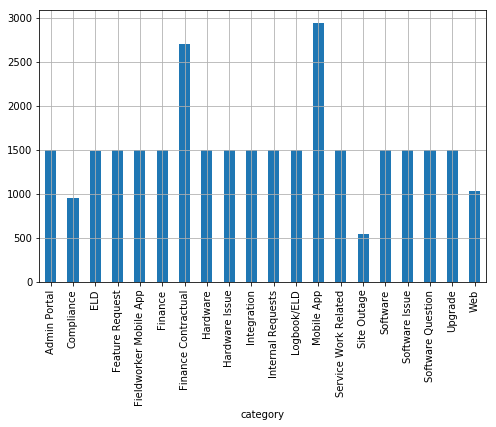

In [16]:
df_stats.plot(x = 'category', 
              y = 'count', 
              kind = 'bar', 
              legend = False, 
              grid = True, 
              figsize = (8,5))

### Preprocess training data

In [17]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.1.0


In [0]:
from fastai import *
from fastai.text import *
path = './'

In [19]:
data.head(5)

,Reason,Description
0,Admin Portal,customer is saying he cannot scroll down insid...
1,Mobile App,Customer Education
2,Site Outage,customer was not able to access FMW for a half...
3,Service Work Related,Customer needs a unit removed from one of thei...
4,Software,Tanner needs his login credentials.


### Pretrained language models

In [0]:
#data_lm = TextDataBunch.from_csv(path, 'data.csv') # load LM from CSV

y = data['Reason']
X = data['Description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
df_train = pd.DataFrame(y_train).join(pd.DataFrame(X_train))
df_valid = pd.DataFrame(y_test).join(pd.DataFrame(X_test))

data_lm = TextLMDataBunch.from_df(path, train_df=df_train, valid_df=df_valid, bs=32) # load LM from DF

In [0]:
data_lm.save('data_lm')

### Tokenization

In [22]:
data_lm.show_batch()

idx,text
0,"as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved"
1,"searched admin , account , why can i not change my payment account number in my profile ? xxmaj or better yet tell me how i change which checking account xxunk my bill ? xxbos ( 12 / 6 / 17 xxup 4:11p ) jsmith : 5 android logbook upsell xxbos xxmaj customer could n't log in . xxbos xxmaj user xxmaj login xxbos xxmaj customer is having issues connecting"
2,xxbos xxmaj michael xxmaj xxunk called in regarding his driver not being able to log in . xxmaj our xxup eld system was completely down for a few hours today . xxbos 10 / 18 / 17 xxup ac ; xxmaj sent xxmaj dave a notice informing him that his acct will be suspended today due to non - payment xxbos xxmaj customer has a few questions concerning xxmaj myob
3,. xxbos https : / / fleetmatics.my.salesforce.com / 0060e xxrep 4 0 xxunk 12 logs xxbos xxup hos xxmaj violation xxmaj issue / xxmaj dashboard xxbos xxmaj just make sure xxup myob stuff is transferring ok xxbos xxmaj customer has a unit not functioning properly in vehicle 101 xxbos xxmaj may 2 2017 xxup ac xxmaj sam xxmaj morin and customer agreed to one month credit -submitting credit to be
4,units ? xxbos xxmaj customer is in collections please turn off login and kill sims xxbos xxmaj customer has questions about xxmaj fuel xxmaj purchased xxmaj report and xxmaj distance xxmaj traveled xxmaj report xxbos xxup fw can not log in xxbos xxmaj lisa called in because ` xxmaj vehicle 53 's odometer is not accurate xxbos xxmaj cody xxmaj smith xxunk xxmaj group : xxup 49lg xxmaj ship :


### Numericalizatio

In [23]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'to',
 'customer',
 '.',
 'the',
 'in',
 'is',
 '/',
 'a',
 'not',
 'and',
 'for']

In [24]:
data_lm.train_ds[0][0]

Text xxbos xxmaj software xxmaj question

In [25]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5, 288,   5, 139])

### With the data block API
We can use the data block API with NLP and have a lot more flexibility than waht the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.
With the data block API though, we have to manually call the tokenize and numericalize steps. This allows mre flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

### Transfer Learning Stages

### Create Language Model

We only need to run the above tokenization step once, and save the data. All the data goes to a local folder named tmp/. For a large added vocabulary, the above tokenization step can take a while, hence we save them and restart the notebook from the next cell (if we close our session).

The tokenization technique used by fastai.text is quite advanced, and uses quite a few tricks to capture semantic meaning from the text. Unlike typical NLTK-type tokenization, here we are not converting the Verbatim to lowercase and removing information from the base text - that would result in a tremendous loss of information that our model could use to gather an understanding of our new task's vocabulary.

Instead, a number of added tokens are applied so that minimal information is lost. A full list of all the tokenization rules used are [here](https://docs.fast.ai/text.transform.html#Rules).

As an example, the xxmaj token [source](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/transform.py#L71) indicates that there is capitalization of the word, either in part or in full. "The" will be tokenized as "xxmaj the". For words that are full capitalized, such as "I AM SHOUTING"; it is tokenized as "xxup i xxup am xxup shouting". The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient.

The tokenization process described above is highly efficient, in part thanks to the power of SpaCy and also due to the multi-threading wrappers implemented by Fast.ai on top of Spacy's tokenizer. As a result, a really large language model's vocabulary (of millions of words) can also be effectively tokenized in a reasonable time.


### Define learner object for language model finetuning

We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model.

This is the first stage of training, where we use the pre-trained language model weights and fine-tune it with the training data of IMDb movie reviews. When we create a learner, we have to pass in two things:

* The data: our language model data (data_lm)
* A pre-trained model: here, the pre-trained model is the Wikitext 103 model that will be downloaded for you from fastai.
    
We use the wt_103_v1 model that was refined after re-training using the more efficient fastai v1 library. The data (lstm_wt103.pth) is downloaded through an AWS-hosted link (accessed through the fastai.datasets interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object itos_wt103.pkl that is similar to the torchtext definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

### Print the structure of the language model RNN

We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined that updates the weights once we pass the input through the network.

In [33]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(7184, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(7184, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=7184, bias=True)
   (output_dp): RNNDropout()
 )]

### Find the optimum learning rate

fastai.train [source](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset.

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below.

**How to fine-tune the pre-trained model on our movie review data?** <br>
Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 6.31E-02


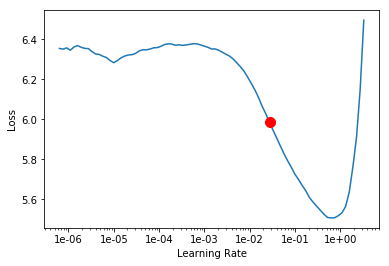

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

### Training the model:
We start training the model with learning rate 1e-2 using fit_one_cycle.

In [0]:
max_lr = 1e-1
min_lr = 1e-2
lr = slice(min_lr, max_lr)

In [35]:
learn.fit_one_cycle(cyc_len = 1,
                    max_lr = min_grad_lr,    # learning rate
                    div_factor = 20,         # factor to discount from max
                    moms =(0.8, 0.7),        # momentums
                    pct_start = 0.1          # where the peak is at
                   )

epoch,train_loss,valid_loss,accuracy,time
0,3.298265,3.081404,0.416090,00:21


In [0]:
learn.save('fit_head')

In [37]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (27594 items)
x: LMTextList
xxbos xxmaj software xxmaj question,xxbos xxmaj terry xxmaj xxunk called because driver wants to use logbook but keeps saying driver license already existed .,xxbos xxmaj vehicle xxmaj inspection,xxbos xxmaj the client is located in xxmaj riverside , xxup mo and their xxup lb reports show the physical location on the map as xxmaj riverside ( and vicinity ) but the city o the xxup lb report shows as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved . xxmaj the client is asking that this be addressed xxup asap as they need to provide the xxup dot official with an update when this is correcte

In [38]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.828093,2.922111,0.438207,00:27
1,2.649088,2.825812,0.453218,00:27
2,2.364300,2.808697,0.457515,00:27
3,2.143015,2.844933,0.456064,00:27


It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze (unfreeze the whole model for training) and train the whole thing.

In [0]:
learn.save_encoder('enc_lstm')
learn.save('model_lstm')

fast.ai library uses latest techniques from deep learning research and one cycle learning is from one of the recent paper and turned out to be both more accurate and faster than any previous approach. First argument ‘1’ is number of epoch runs . We get an accuracy of 30.3% after running just one epoch.

It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze (unfreeze the whole model for training) and train the whole thing.

### Predicting with Language Model

To evaluate our language model, we can now run learn.predict and pass in the start of a sentence and specify the number of words we want it to guess.

In [40]:
learn.predict('Hello, Do we have the driver dispatch/Fleetmatics Work option on our account?', n_words=30)

'Hello, Do we have the driver dispatch/Fleetmatics Work option on our account? i have had no communication for this and are unable to provide the driver on overview as to what type of thing he done for our program so i do'

In [0]:
learn.save_encoder('fine_enc')

### Creating the classifier

Now we’re ready to create our classifier. Step one, is to create a data bunch, TextClasDataBunch, passing the vocab from the language model to make sure that this data bunch is going to have exactly the same vocab. Batch size bs to be used is according to the GPU memory you have available, for a 2GB GPU around bs=5 will work fine. You can find whatever batch size fits on your card and use it accordingly.

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./'
                                      ,train_df=df_train
                                      ,valid_df=df_valid
                                      ,vocab=data_lm.train_ds.vocab
                                      ,bs=32)

In [43]:
data_clas.show_batch()

text,target
xxbos [ http : / / xxunk / en - us / xxunk / xxunk = xxunk - xxunk ] xxmaj your message to k.chavez@sunotec-group.com could n't be delivered . k.chavez was n't found at sunotec-group.com . helpdesk = xxunk . . . xxmaj office 365 k.chavez xxmaj action xxmaj required xxmaj recipient xxmaj unknown xxmaj to address xxmaj how to xxmaj fix xxmaj it xxmaj the address may be,Internal Requests
"xxbos xxmaj hi xxmaj anthony , xxmaj the customer has confirmed for 4 / 10 at 9:30am . * xxmaj thanks for choosing xxup drig ! * * xxmaj susan xxmaj taylor * * xxup drig xxmaj field xxmaj account xxmaj coordinator * 970 - 680 - xxunk susan.drig@gmail.com visit us at : xxunk * xxup drig xxmaj tech xxmaj map < https : / / urldefense.proofpoint.com / v2 /",Internal Requests
"xxbos 15 march 2017 xxup edp xxmaj customer was denied cancellation looking to xxunk contract in full sent over to xxup ar / collections closing case as non renewal xxmaj from : xxmaj cathy xxmaj young [ xxunk ] xxmaj sent : xxmaj wednesday , xxmaj march 15 , 2017 xxunk xxup am xxmaj to : xxmaj eric xxmaj perez < eric.perez@fleetmatics.com > xxmaj subject : xxmaj re : xxmaj",Finance
"xxbos i just left you a message regarding the new xxup gps units that were sent the other day . i believe they got put w / the wrong drivers . xxmaj we have on that is reading in xxmaj xxunk , xxup ky . , but the driver is here in xxmaj madison , xxup tn . w / the xxup gps unit xxup not even installed on his",Internal Requests
"xxbos i have been trying to get our tablets online so that our drivers can log in to the elogs . xxmaj in your logbook driver guide , under login , it states : 1 ) login using your unique xxmaj driver xxup id provided from you fleetmatics admin . 2 ) xxmaj the xxmaj driver xxup id must be verified by xxmaj reveal on initial login 3 ) xxmaj",Logbook/ELD


In [44]:
# Classifier
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (27594 items)
x: TextList
xxbos xxmaj software xxmaj question,xxbos xxmaj terry xxmaj xxunk called because driver wants to use logbook but keeps saying driver license already existed .,xxbos xxmaj vehicle xxmaj inspection,xxbos xxmaj the client is located in xxmaj riverside , xxup mo and their xxup lb reports show the physical location on the map as xxmaj riverside ( and vicinity ) but the city o the xxup lb report shows as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved . xxmaj the client is asking that this be addressed xxup asap as they need to provide the xxup dot official with an update when this is corrected . x

### Find Learning Rate

In [45]:
classifier.freeze()
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-02
Min loss divided by 10: 2.09E-02


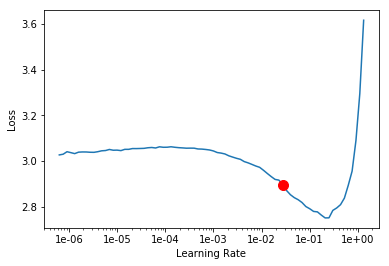

In [46]:
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [47]:
classifier.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.708051,1.482891,0.527071,00:23


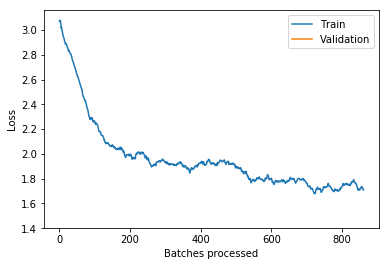

In [48]:
classifier.recorder.plot_losses()

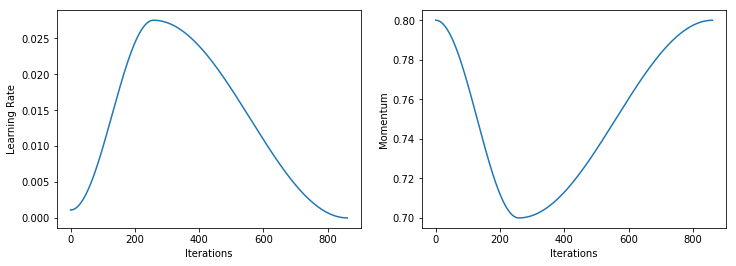

In [49]:
classifier.recorder.plot_lr(show_moms=True)

In [0]:
classifier.save('first')

In [51]:
classifier.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (27594 items)
x: TextList
xxbos xxmaj software xxmaj question,xxbos xxmaj terry xxmaj xxunk called because driver wants to use logbook but keeps saying driver license already existed .,xxbos xxmaj vehicle xxmaj inspection,xxbos xxmaj the client is located in xxmaj riverside , xxup mo and their xxup lb reports show the physical location on the map as xxmaj riverside ( and vicinity ) but the city o the xxup lb report shows as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved . xxmaj the client is asking that this be addressed xxup asap as they need to provide the xxup dot official with an update when this is corrected . x

### Fine-Tune further

To improve the accuracy further, fast.ai provides some more tricks;freeze_to. Don't unfreeze the whole thing but to unfreeze one layer at a time. The below approach works very well and gives incredible results.

* unfreeze the last two layers freeze_to(-2), train it a little bit more
* unfreeze the next layer freeze_to(-3), train it a little bit more
* unfreeze the whole thing unfreeze(), train it a little bit more

In [52]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.45E-04


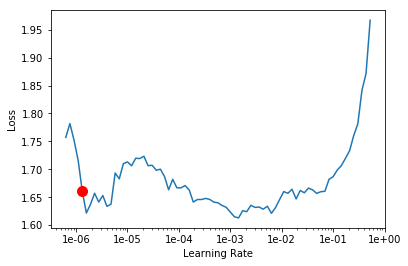

In [53]:
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [54]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.604894,1.423255,0.556099,00:25
1,1.396065,1.242336,0.595564,00:25
2,1.254380,1.214139,0.601761,00:25


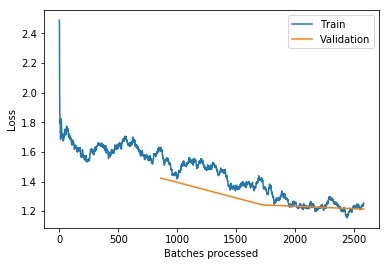

In [55]:
classifier.recorder.plot_losses()

In [0]:
classifier.save('second')

In [57]:
classifier.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (27594 items)
x: TextList
xxbos xxmaj software xxmaj question,xxbos xxmaj terry xxmaj xxunk called because driver wants to use logbook but keeps saying driver license already existed .,xxbos xxmaj vehicle xxmaj inspection,xxbos xxmaj the client is located in xxmaj riverside , xxup mo and their xxup lb reports show the physical location on the map as xxmaj riverside ( and vicinity ) but the city o the xxup lb report shows as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved . xxmaj the client is asking that this be addressed xxup asap as they need to provide the xxup dot official with an update when this is corrected . x

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


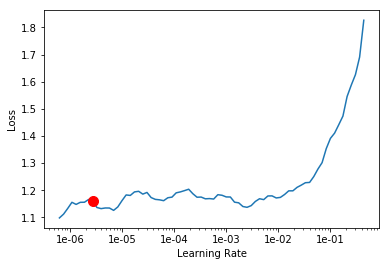

In [58]:
classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [59]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.248283,1.222496,0.606001,00:40
1,1.126689,1.189220,0.617417,00:40
2,0.936719,1.186068,0.622309,00:41


In [60]:
classifier.save('third')
classifier.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (27594 items)
x: TextList
xxbos xxmaj software xxmaj question,xxbos xxmaj terry xxmaj xxunk called because driver wants to use logbook but keeps saying driver license already existed .,xxbos xxmaj vehicle xxmaj inspection,xxbos xxmaj the client is located in xxmaj riverside , xxup mo and their xxup lb reports show the physical location on the map as xxmaj riverside ( and vicinity ) but the city o the xxup lb report shows as xxmaj parkdale , xxup mo which is the other side of the state , which they have no business anywhere near that location . xxmaj this has resulted in an issue with a xxup dot official reviewing a drivers lbs that show this and that client stated that when they spoke with support previously , they were told to themselves , contact xxmaj google to get the issue resolved . xxmaj the client is asking that this be addressed xxup asap as they need to provide the xxup dot official with an update when this is corrected . x

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 5.75E-07


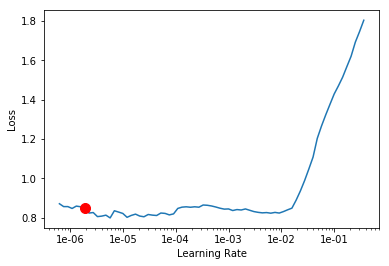

In [61]:
classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [62]:
classifier.unfreeze()
classifier.fit_one_cycle(5, slice(1e-5/(2.6**4), 1e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.881365,1.188550,0.626875,00:55
1,0.880307,1.193862,0.622635,00:53
2,0.860807,1.203683,0.624592,00:55
3,0.929577,1.196142,0.622635,00:56
4,0.881868,1.192677,0.625897,00:51


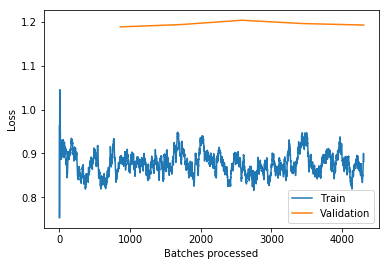

In [63]:
classifier.recorder.plot_losses()

In [64]:
classifier.save('final')
classifier.show_results()

text,target,prediction
xxbos xxmaj description of xxmaj issue ( xxmaj detailed ! ) : - xxmaj client needs assistance setting up xxmaj xxunk rule set - client received instructions but needs assistance establishing rule - set in her account - xxmaj please reach out to client pertaining eld rule - set - please see instructions sent to client below xxrep 67 - xxmaj back xxmaj office xxmaj set - up & xxmaj,Compliance,Compliance
"xxbos 13 xxmaj july 2017 xxup rbj -spoke to xxmaj ashlee regarding issues xxup xxunk sync not working , open case xxunk since 6 / 22 xxunk : xxmaj xxunk xxmaj warren [ xxunk ] xxmaj sent : xxmaj wednesday , xxmaj july 12 , 2017 3:00 xxup pm xxmaj to : xxmaj rob xxmaj jarvis < rob.jarvis@fleetmatics.com > xxmaj subject : xxup re : xxmaj fleetmatics xxup work xxmaj",Integration,Finance
"xxbos xxmaj from : xxmaj sean xxmaj duffy xxmaj sent : xxmaj wednesday , xxmaj april 12 , 2017 xxunk xxup am xxmaj to : xxmaj james xxmaj johnson < james.johnson@fleetmatics.com > ; xxmaj shannon xxmaj xxunk < xxunk > xxmaj subject : xxup fw : xxmaj cancel xxmaj xxunk xxup work xxmaj hi xxmaj team , xxmaj below is the approval to cancel xxup work for all xxmaj xxunk",Finance,Finance
"xxbos xxmaj hi xxmaj rita , xxmaj please cancel our xxunk subscription . xxmaj ralph informed us that we would have a full month to try out the software before xxunk and that xxunk he had to put us on a xxunk contract to push it through , but that it was no - xxunk and that we could cancel at any point with no cancellation fees and no hassle",Finance,Finance
"xxbos 27 xxmaj mar 2017 xxup mkz -closing case xxunk users in xxup gr xxunk customer 21 xxmaj mar 2017 xxup mkz -customer is looking to cancel xxunk 3 > xxunk swap , xxup dot pre - trip xxunk , xxunk tracking -customer is not able to integrate quickbooks xxmaj desktop & xxup work : company file xxunk on xxup mac server xxrep 52 _ xxmaj please see attached for",Finance,Finance


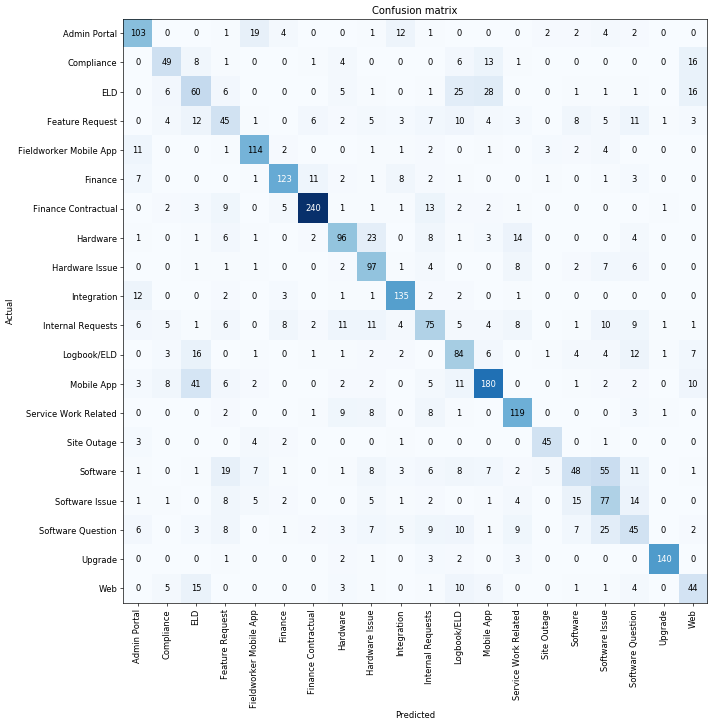

In [65]:
from fastai.vision import *
interp = ClassificationInterpretation.from_learner(classifier)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)